# **Creazione di modelli per la classificazione di emozioni da file audio .wav**

**Corso**: Big Data

**Professore**: Diego Angelo Gaetano Reforgiato Recupero

**Studenti**: Daniele Lurani, Lorenzo Susino


## **Importazioni e configurazioni iniziali**
In questa sezione vengono importate le librerie necessarie per il progetto (ad esempio, `pandas`, `numpy`, `matplotlib`, ecc.) e configurati eventuali parametri di visualizzazione o impostazioni iniziali per il notebook.


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.version)
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc=spark.sparkContext

--2025-03-13 15:33:15--  https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.208.237, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.208.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz’

spark-3.5.5-bin-had 100%[===================>] 382.16M  13.2MB/s    in 46s     

2025-03-13 15:34:01 (8.38 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz’ saved [400724056/400724056]

<module 'pyspark.version' from '/content/spark-3.5.5-bin-hadoop3/python/pyspark/version.py'>


In [2]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 49.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib
import sklearn
import numpy as np
import speech_recognition as sr
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, log_loss

In [4]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/My Drive/BigData_Project/dataset'
english_path = base_path + '/english'
german_path = base_path + '/german'
french_path = base_path + '/french'

Mounted at /content/drive


## **Funzioni di estrazione features**

Questa sezione si occupa di definire le funzioni che verranno utilizzate per la lettura dei file e per l'estrazione delle features.

In [5]:
# Funzione per estrarre testo dall'audio
def extract_text_from_audio(audio_file_path):
    # Inizializza recognizer
    recognizer = sr.Recognizer()

    try:
        # Carica il file audio
        audio_file = sr.AudioFile(audio_file_path)

        with audio_file as source:
            # Registra l'audio
            audio_data = recognizer.record(source)

            # UtilizGza oogle Speech Recognition
            text = recognizer.recognize_google(audio_data, language="fr-FR")
            return text
    except Exception as e:
        print(f"Errore nell'estrazione del testo da {audio_file_path}: {e}")
        return ""

# Funzione ricorsiva per trovare tutti i file .wav e ottenere l'emozione dalla cartella
def find_audio_files_recursive(root_folder):
    texts = []
    labels = []
    file_paths = []

    for dirpath, dirnames, filenames in os.walk(root_folder):
        # Ottieni l'emozione dal nome dell'ultima cartella nel percorso
        emotion = os.path.basename(dirpath)

        for filename in filenames:
            if filename.endswith('.wav'):
                file_path = os.path.join(dirpath, filename)

                # Estrai testo dall'audio
                text = extract_text_from_audio(file_path)

                if text:  # Solo se il testo è stato estratto con successo
                    texts.append(text)
                    labels.append(emotion)
                    file_paths.append(file_path)

    return texts, labels, file_paths




## **Lavoro su Dataset Francese**

In questa sezione viene effettuata l'analisi delle emozioni di un dataset in lingua francese basandosi su feature testuali e su modelli supervisionati

Estrazione features e settaggio dei DataFrame

Preprocessing del dataset:
- Creazione della pipeline
- Split del dataset in train e test sets


In [6]:
# Creazione del modello pipeline
def create_model(model_type):
    if model_type == 'rf':
      pipeline = Pipeline([
          ('vectorizer', TfidfVectorizer(max_features=1000)),
          ('classifier', RandomForestClassifier())
      ])
    else :
      pipeline = Pipeline([
          ('vectorizer', TfidfVectorizer(max_features=1000)),
          ('classifier', GradientBoostingClassifier())
      ])

    return pipeline

# Funzione per predire l'emozione di un nuovo file audio
def predict_emotion(model, audio_file_path):
    text = extract_text_from_audio(audio_file_path)
    if not text:
        return "Impossibile estrarre testo dall'audio"

    prediction = model.predict([text])[0]
    return prediction

In [7]:
root_folder = french_path
test_size = 0.2

# Prepara il dataset
texts, labels, file_paths = find_audio_files_recursive(root_folder)

# Dividi in train e test
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=test_size)

Errore nell'estrazione del testo da /content/drive/My Drive/BigData_Project/dataset/french/angry/20a01Ca.wav: 
Errore nell'estrazione del testo da /content/drive/My Drive/BigData_Project/dataset/french/angry/25a06Ca.wav: 


### Random Forest e Gradient Boosting

Creazione e addestramento del modelli RandomForest e GradientBoosting

In [8]:
from sklearn.metrics import accuracy_score, precision_score, log_loss, f1_score, roc_auc_score

model_rf = create_model("rf")
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
french_rf_proba = model_rf.predict_proba(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted')
f1_rf = f1_score(y_test, y_pred, average='weighted')
auc_rf = roc_auc_score(y_test, french_rf_proba, multi_class='ovr')

print("\nMetriche del Random Forest")
print(f"Accuratezza: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"AUC-ROC: {auc_rf:.4f}")


Metriche del Random Forest
Accuratezza: 0.9692
Precision: 0.9740
F1-Score: 0.9697
AUC-ROC: 0.9992


In [9]:
model_gb = create_model("gb")
model_gb.fit(X_train, y_train)

y_pred = model_gb.predict(X_test)
french_gb_proba = model_gb.predict_proba(X_test)

accuracy_gb = accuracy_score(y_test, y_pred)
precision_gb = precision_score(y_test, y_pred, average='weighted')
f1_gb = f1_score(y_test, y_pred, average='weighted')
auc_gb = roc_auc_score(y_test, french_gb_proba, multi_class='ovr')

print("\nMetriche del Gradient Boosting")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"F1-Score: {f1_gb:.4f}")
print(f"AUC-ROC: {auc_gb:.4f}")


Metriche del Gradient Boosting
Accuracy: 0.9692
Precision: 0.9714
F1-Score: 0.9694
AUC-ROC: 0.9988


Confronto dei risultati ottenuti

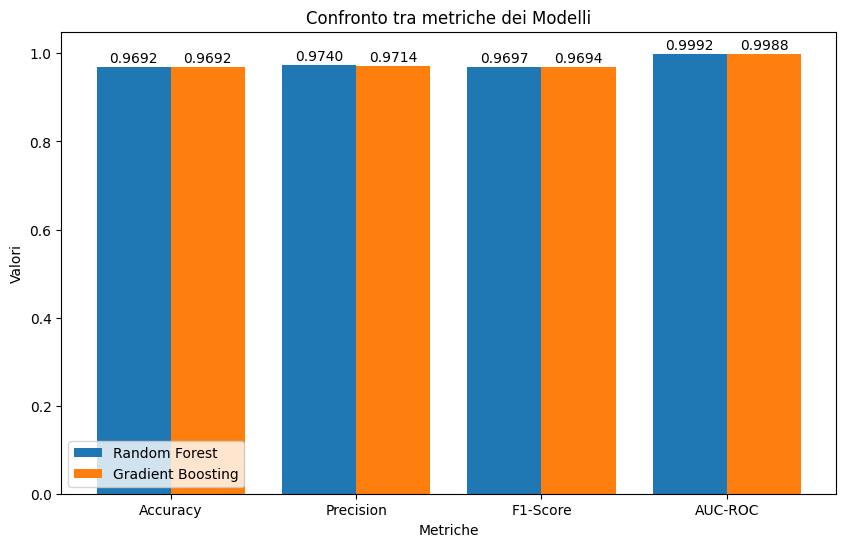

In [11]:
# Confronto metriche Random Forest
X = ['Accuracy','Precision','F1-Score', 'AUC-ROC']
rf = [accuracy_rf, precision_rf, f1_rf, auc_rf]
gb = [accuracy_gb, precision_gb, f1_gb, auc_gb]
X_axis = np.arange(len(X))

plt.figure(figsize=(10, 6))

plt.bar(X_axis - 0.2, rf, 0.4, label = 'Random Forest')
plt.bar(X_axis + 0.2, gb, 0.4, label = 'Gradient Boosting')

for i in range(len(X)):
    plt.text(X_axis[i] - 0.2, rf[i] + 0.01, f'{rf[i]:.4f}', ha='center')
    plt.text(X_axis[i] + 0.2, gb[i] + 0.01, f'{gb[i]:.4f}', ha='center')

plt.xticks(X_axis, X)
plt.xlabel("Metriche")
plt.ylabel("Valori")
plt.title("Confronto tra metriche dei Modelli")
plt.legend()
plt.show()